# Imports 

In [656]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import swifter
import scipy.stats as sps
import plotly.express as px
pd.set_option('max_columns', None)
from tqdm.notebook import tqdm
from itertools import product
from soccer_xg import XGModel, DataApi, xg
from fuzzywuzzy import fuzz
from unidecode import unidecode
import regex as re
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler
import pickle

In [3]:
#pd.set_option('max_colwidth', 999)
pd.set_option('display.max_columns', 1000)
pd.set_option("display.max_rows", 3000)

In [419]:
import warnings
warnings.filterwarnings('ignore')

# Data 

## Generate xG for PL 17-18 

In [37]:
provider = 'wyscout_opensource'
leagues = ['ENG', 'ESP', 'ITA', 'GER', 'FRA']
seasons = ['1718']
api = DataApi([
    f"../data/vaep/h5_files/spadl-{provider}-{l}-{s}.h5"
    for (l, s) in product(leagues, seasons)
])

In [38]:
#load pre-trained model
xg_model = xg.XGModel.load_model(
    f'openplay_xgboost_advanced')  # custom pipeline for open play shots

In [39]:
xg_model.train(api, training_seasons=[('ENG', '1718'), ('ESP', '1718'), ('ITA', '1718'), ('FRA', '1718'), ('GER', '1718')])

Generating labels: 100%|██████████████████████████████████████████████████████████████████████████| 1826/1826 [00:53<00:00, 34.38it/s]


Generating features: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [01:52<00:00,  3.39it/s]
No handles with labels found to put in legend.


{'max_dev': 17.198703619756884,
 'residual_area': 485.9176859010821,
 'roc': 0.8360929262465635,
 'brier': 0.07624689231692355,
 'ece': 0.0124419481637788,
 'ace': 0.011993946697342099,
 'fig': <Figure size 720x360 with 3 Axes>}

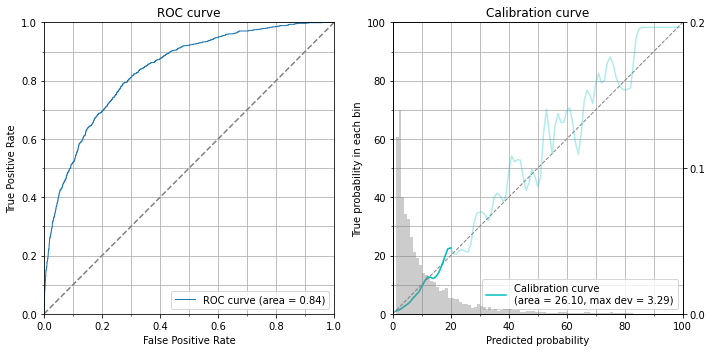

In [40]:
xg_model.validate(api, validation_seasons=[('ENG', '1718')])

In [53]:
df_games = pd.read_hdf(
    '../data/vaep/h5_files/spadl.h5',
    key='games')
df_games.head()

,game_id,competition_id,season_id,game_date,home_team_id,away_team_id
0,2500089,364,181150,2018-05-13 14:00:00,1646,1659
1,2500090,364,181150,2018-05-13 14:00:00,1628,1627
2,2500091,364,181150,2018-05-13 14:00:00,1673,1609
3,2500092,364,181150,2018-05-13 14:00:00,1612,1651
4,2500093,364,181150,2018-05-13 14:00:00,1611,1644


In [54]:
# # predict xG values
xg_pl = xg_model.estimate(api, game_ids=list(df_games[df_games['competition_id']==364]['game_id'].values))

Generating features: 100%|██████████████████████████████████████████████████████████████████████████| 380/380 [02:19<00:00,  2.72it/s]


In [55]:
xg_pl.to_pickle('../data/vaep/xG_pl.pkl')

In [64]:
xg_pl

xG
game_id action_id          
2500089 276        0.101725
        314        0.037059
        368        0.057251
        374        0.039816
        401        0.057477
...                     ...
2499719 1149       0.049527
        1157       0.267522
        1184       0.093349
        1187       0.103965
        1286       0.026161

[8451 rows x 1 columns]

## Compute xG vs off_value per defender for optimal action window   

In [49]:
vaep = pd.read_pickle('../data/vaep/vaep_values.pkl')
player = pd.read_pickle('../data/players/players.pkl')
match_def = pd.read_pickle('../data/matches/match+def_lineup+footedness_ver2.pkl')

In [117]:
vaep = vaep.replace({'short_team_name':{
        'Manchester United': 'Man Utd',
        'Tottenham Hotspur': 'Spurs',
        'West Ham United': 'West Ham',
        'Manchester City': 'Man City',
        'Brighton & Hove Albion': 'Brighton',
        'Stoke City': 'Stoke',
        'AFC Bournemouth': 'Bournemouth',
        'West Bromwich Albion': 'West Brom',
        'Leicester City': 'Leicester',
        'Swansea City': 'Swansea',
        'Huddersfield Town': 'Huddersfield',
        'Newcastle United': 'Newcastle'
    }}
)

vaep['full_name'] = vaep['first_name']+vaep['last_name']
vaep['full_name'] = vaep['full_name'].astype(str).apply(lambda x: unidecode(x))
vaep['full_name'] = vaep['full_name'].apply(lambda x: x.replace('-', ''))
vaep['full_name'] = vaep['full_name'].apply(lambda x: x.replace(' ', ''))

In [429]:
def match_names(name, l):
    tatb = ['RCB', 'CB', 'LCB']
    fatb = ['RB', 'R_CB', 'L_CB', 'LB']
    fiatb = ['RWB', 'RCB', 'CB', 'LCB', 'LWB']
    player_map = {
        'RamiroFunesMori': 'JoseRamiroFunesMori',
        'KurtZouma': 'KurtHappyZouma',
        'Danilo': 'DaniloLuizdaSilva',
        'CesarAzpilicueta': 'CesarAzpilicuetaTanco',
        'EzequielSchelotto': 'MatiasEzequielSchelotto',
        'GaetanBong': 'GaetanBongSongo',
        'HectorBellerin': 'HectorBellerinMoruno',
        'AhmedHegazi': 'AhmedHegazy',
        'JamaalLascelles': 'JamalLascelles',
        'AngelRangel': 'AngelRangelZaragoza',
        'Zanka': 'MathiasJattahNjieJorgensen',
        'ChrisLwe': 'ChrisLowe',
        'EricBailly': 'EricBertrandBailly',
        'MarcosRojo': 'FaustinoMarcosAlbertoRojo',
        'CdricSoares': 'CedricRicardoAlvesSoares',
        'AngeloOgbonna': 'AngeloObinzeOgbonna',
        'HctorBellern': 'HectorBellerinMoruno',
        'DavinsonSanchez': 'DavinsonSanchezMina',
        'JavierManquillo': 'JavierManquilloGaitan',
        'TommySmith': 'TomSmith',
        'Bruno': 'BrunoSaltorGrau',
        'GatanBong': 'GaetanBongSongo',
        'NicolsOtamendi': 'NicolasHernanOtamendi',
        'CsarAzpilicueta': 'CesarAzpilicuetaTanco',
        'AntonioRdiger': 'AntonioRudiger',
        'JosHolebas': 'JoseHolebas',
        'SamusColeman': 'SeamusColeman',
        'AllanRomoNyom': 'AllanRomeoNyom',
        'NathanAk': 'NathanAke',
        'JosephGomez': 'JoeGomez',
        'AlbertoMoreno': 'AlbertoMorenoPerez',
        'LuisAntonioValencia': 'LuisAntonioValenciaMosquera',
        'VictorLindelf': 'VictorNilssonLindelof',
        'DavinsonSnchez': 'DavinsonSanchezMina',
        'NicolasOtamendi': 'NicolasHernanOtamendi',
        'NachoMonreal': 'IgnacioMonrealEraso',
        'FedericoFernndez': 'FedericoFernandez',
        'SebastianPrdl': 'SebastianProdl',
        'CedricSoares': 'CedricRicardoAlvesSoares',
        'JoelMatip': 'JoelAndreJobMatip',
        'MiguelBritos': 'MiguelAngelBritosCabrera',
        'VictorLindelof': 'VictorNilssonLindelof',
        'JamesCollins': 'JamesMichaelCollins',
        'CucoMartina': 'RhuendlyMartina',
        'DavidLuiz': 'DavidLuizMoreiraMarinho',
        'MollaWagu': 'MollaWague',
        'JrmyPied': 'JeremyPied',
        'ChancelMbemba': 'ChancelMbembaMangulu',
        'PabloZabaleta': 'PabloJavierZabaletaGirod',
        'KikoFemenia': 'FranciscoFemeniaFar',
        'CheikhouKouyat': 'CheikhouKouyate',
        'KikoFemena': 'FranciscoFemeniaFar',
        'JoseFonte': 'JoseMigueldaRochaFonte',
        'JosFonte': 'JoseMigueldaRochaFonte',
        'JesusGamez': 'JesusGamezDuarte'
    }
    res = []
    for i in range(len(l)):
        try:
            l[i] = player_map[l[i]]
        except:
            pass
        split_player = re.findall('[A-Z][^A-Z]*', l[i])
        if((split_player[-1] in name)==True):
            if(len(l)==3):
                res = [tatb[i], l[i]]
                break
            elif(len(l)==4):
                res = [fatb[i], l[i]]
                break
            elif(len(l)==5):
                res = [fiatb[i], l[i]]
                break
        elif((split_player[-1] in name)==False):
            res = ['not', l[i]]
    
    return res

In [593]:
def compute_xG_vs_offval(cutoff_xg, n):
    df = pd.DataFrame(columns=[
        'player_name', 'position', 'match_id', 'team', 'off_val_opp', 'num',
        'denom'
    ])
    cutoff_xg_pl = xg_pl[xg_pl['xG'] >= cutoff_xg]

    for i in tqdm(cutoff_xg_pl.index):
        a = vaep[vaep['game_id'] == i[0]].reset_index(drop=True)
        opp_team = a.loc[i[1]]['short_team_name']
        try:
            cand = list(a.loc[(i[1] - n):i[1]]['full_name'].values)
            cand = [(cand[k], (i[1] - n + k)) for k in range(len(cand))
                    if (a[a['full_name'] == cand[k]]
                        ['short_team_name'].values[0] == opp_team)
                    & (player[player['playerName'] == cand[k]]
                       ['role'].values[0]['code3'] == 'DEF')
                    & (a.loc[(i[1] - n + k)]['type_name'] == 'pass')]

            for j in range(len(cand)):
                def_line = match_def[(match_def['wyId'] == i[0]) & (
                    match_def['team'] == opp_team)]['team_defense']
                res = match_names(cand[j][0], def_line.values[0])
                if (res[0] != 'not'):
                    num = a.loc[cand[j][1]]['offensive_value']
                    denom = a.loc[(i[1] - n):i[1]]['offensive_value'].sum()
                    off_val_opp = (num) / (denom)
                    row = {
                        'player_name': res[1],
                        'position': res[0],
                        'match_id': i[0],
                        'team': opp_team,
                        'off_val_opp': off_val_opp,
                        'num': num,
                        'denom': denom
                    }
                    df = df.append(row, ignore_index=True)
                else:
                    continue
        except:
            pass
    return df

(0.0, 0.5)

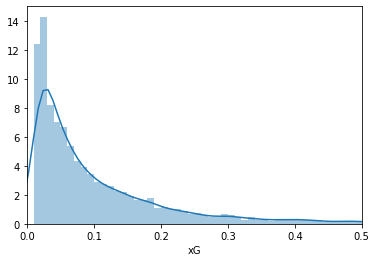

In [594]:
ax = sns.distplot(xg_pl['xG'], kde=True, hist=True, hist_kws={"range": [0,0.5]})
ax.set_xlim(0, 0.5)

In [705]:
off_val_opp_df = compute_xG_vs_offval(0.25, 5)

In [706]:
off_val_opp_df

,player_name,position,match_id,team,off_val_opp,num,denom
0,MamadouSakho,L_CB,2500090,Crystal Palace,0.002151,0.002132,0.991345
1,FlorentHadergjonaj,RWB,2500091,Huddersfield,-0.359458,0.012915,-0.035928
2,ShkodranMustafi,R_CB,2500091,Arsenal,-3.473009,0.142943,-0.041158
3,RobHolding,L_CB,2500091,Arsenal,0.021364,0.000651,0.030465
4,TrentAlexanderArnold,RB,2500092,Liverpool,0.038857,0.037971,0.977210
5,DejanLovren,R_CB,2500092,Liverpool,0.062139,0.003191,0.051355
6,DejanLovren,R_CB,2500092,Liverpool,0.014192,0.000626,0.044111
7,TrentAlexanderArnold,RB,2500092,Liverpool,0.108802,0.004799,0.044111
8,AndrewRobertson,LB,2500092,Liverpool,0.046911,0.001543,0.032887
9,AndrewRobertson,LB,2500092,Liverpool,-0.005114,-0.004812,0.940785


In [707]:
off_val_opp_df['position'].value_counts()

RB      100
LB       75
L_CB     75
R_CB     74
LCB      37
CB       26
RCB      24
LWB       4
RWB       3
Name: position, dtype: int64

In [727]:
df = off_val_opp_df

In [728]:
df_scale = df[['num', 'denom']]
df_scale = pd.DataFrame(MinMaxScaler().fit_transform(df_scale), columns = ['num', 'denom'])

In [729]:
df['off_val_opp'] = df_scale['num']/df_scale['denom']

In [730]:
df1 = pd.DataFrame(
    df.groupby([
        'player_name',
        'position',
        'team',
        'match_id',
    ])['off_val_opp'].mean()).reset_index()

df1 = pd.DataFrame(
    df1.groupby(['player_name', 'position', 'team'
                            ])['off_val_opp'].sum()).reset_index()

df1['off_val_opp'] = df1.apply(lambda x: (x.off_val_opp) / len(vaep[vaep[
    'full_name'] == x.player_name]['game_id'].unique()), axis=1)

In [731]:
df = pd.DataFrame(
    df.groupby(['player_name', 'position', 'team'
                            ])['off_val_opp'].sum()).reset_index()

In [732]:
df['off_val_opp_avg'] = df1['off_val_opp']
df.columns = ['player_name', 'position', 'team', 'off_val_opp_sum', 'off_val_opp_avg']

In [733]:
df

,player_name,position,team,off_val_opp_sum,off_val_opp_avg
0,AaronCresswell,LB,West Ham,0.183867,0.005107
1,AaronCresswell,LCB,West Ham,4.509658,0.085747
2,AaronWanBissaka,RB,Crystal Palace,1.627672,0.232525
3,AdamSmith,LB,Bournemouth,1.456683,0.053951
4,AdrianMariappa,RB,Watford,1.411601,0.050414
5,AhmedHegazy,LCB,West Brom,0.170989,0.004500
6,AhmedHegazy,L_CB,West Brom,0.217532,0.005725
7,AhmedHegazy,R_CB,West Brom,2.411300,0.063455
8,AlbertoMorenoPerez,LB,Liverpool,1.113021,0.069564
9,AleksandarDragovic,R_CB,Leicester,2.189169,0.147674


In [734]:
len(df)

158

# Viz 

In [735]:
df2 = df[df['position'].str.contains('CB')].reset_index(drop=True)

In [739]:
df2 = df2[df2['player_name']!='MikevanderHoorn']

In [740]:
df2.sort_values(by=['off_val_opp_avg'], ascending=False)

,player_name,position,team,off_val_opp_sum,off_val_opp_avg
50,KyleBartley,R_CB,Swansea,4.804526,0.960905
63,NicolasHernanOtamendi,L_CB,Man City,19.254975,0.533087
23,ConnorGoldson,RCB,Brighton,1.109096,0.369699
77,ShkodranMustafi,R_CB,Arsenal,9.718353,0.353481
56,MathiasJattahNjieJorgensen,R_CB,Huddersfield,12.357197,0.315583
84,VincentKompany,R_CB,Man City,7.762739,0.304361
9,AntonioRudiger,LCB,Chelsea,8.558600,0.294844
43,JoelAndreJobMatip,R_CB,Liverpool,6.703282,0.279303
16,CesarAzpilicuetaTanco,RCB,Chelsea,14.367123,0.278007
72,ScottDann,R_CB,Crystal Palace,4.715989,0.277411


In [741]:
df2.sort_values(by=['off_val_opp_sum'], ascending=False)

,player_name,position,team,off_val_opp_sum,off_val_opp_avg
63,NicolasHernanOtamendi,L_CB,Man City,19.254975,0.533087
16,CesarAzpilicuetaTanco,RCB,Chelsea,14.367123,0.278007
56,MathiasJattahNjieJorgensen,R_CB,Huddersfield,12.357197,0.315583
74,ShaneDuffy,R_CB,Brighton,9.727893,0.262916
77,ShkodranMustafi,R_CB,Arsenal,9.718353,0.353481
9,AntonioRudiger,LCB,Chelsea,8.558600,0.294844
7,AndreasChristensen,CB,Chelsea,8.257859,0.262255
84,VincentKompany,R_CB,Man City,7.762739,0.304361
35,HarryMaguire,L_CB,Leicester,7.718205,0.193118
31,FlorianLejeune,L_CB,Newcastle,7.415392,0.196358


In [742]:
print(df2['off_val_opp_avg'].max())
print(df2['off_val_opp_avg'].min())

0.9609052851335509
0.003618764543540303


In [743]:
print(df2['off_val_opp_sum'].max())
print(df2['off_val_opp_sum'].min())

19.254974518999546
0.1375130526545315


<AxesSubplot:xlabel='off_val_opp_avg'>

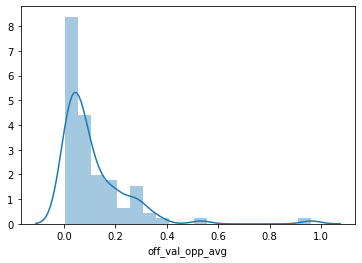

In [744]:
sns.distplot(df2['off_val_opp_avg'])

<AxesSubplot:xlabel='off_val_opp_sum'>

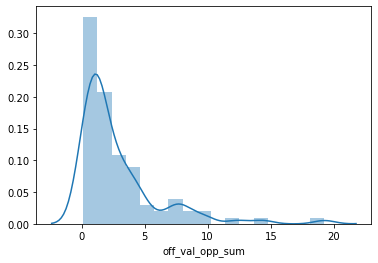

In [745]:
sns.distplot(df2['off_val_opp_sum'])

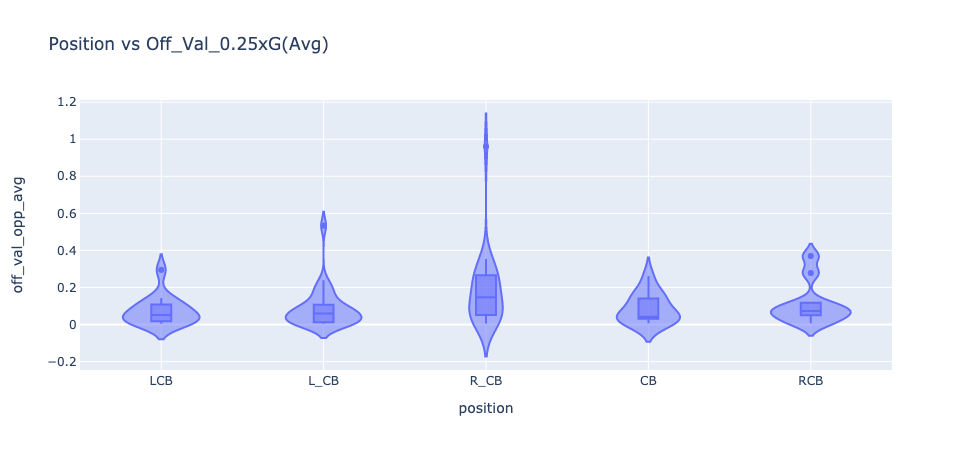

In [746]:
fig = px.violin(df2,
                x='position',
                y='off_val_opp_avg',
                title=r'Position vs Off_Val_0.25xG(Avg)',
                hover_data=['player_name'],
                box=True)
                #points='all')
fig.show()

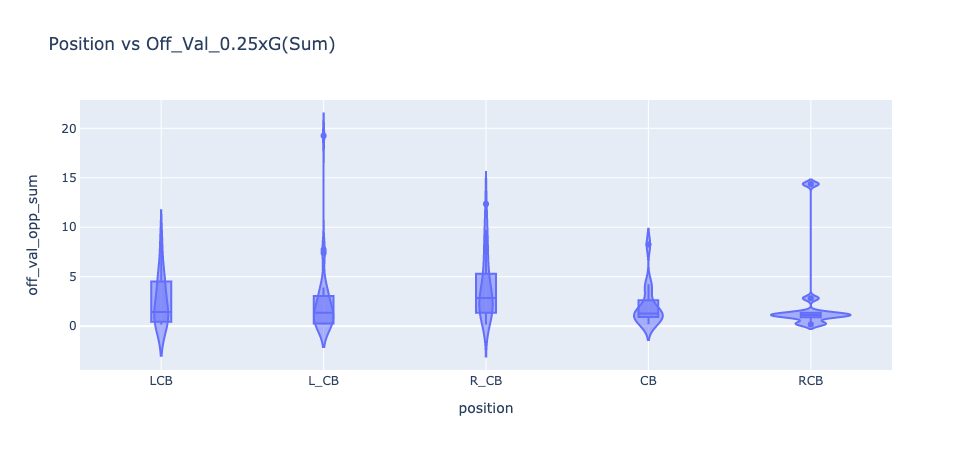

In [747]:
fig = px.violin(df2,
                x='position',
                y='off_val_opp_sum',
                title=r'Position vs Off_Val_0.25xG(Sum)',
                hover_data=['player_name'],
                box=True)
                #points='all')
fig.show()

# Merging with Player Metrics DF 

In [660]:
uni = pd.read_pickle('../../footedness/data/defender_clusters/defender_attrs_def_region_wise.pkl')

In [661]:
df.head()

,player_name,position,team,off_val_opp_sum,off_val_opp_avg
0,AaronCresswell,LCB,West Ham,4.404048,0.083739
1,AhmedHegazy,LCB,West Brom,0.166984,0.004394
2,AhmedHegazy,L_CB,West Brom,0.212438,0.005590
3,AhmedHegazy,R_CB,West Brom,2.354830,0.061969
4,AleksandarDragovic,R_CB,Leicester,2.137902,0.144215


In [662]:
uni.head()

,index,player_name,team,position,footedness,matches_played,passes,accpass,progaccpass,proginaccpass,accpassloc,inaccpassloc,progaccpassloc,proginaccpassloc,accpassvaep,inaccpassvaep,progaccpassvaep,proginaccpassvaep,accpassoff,inaccpassoff,progaccpassoff,proginaccpassoff,accpassdef,inaccpassdef,progaccpassdef,proginaccpassdef,progaccidx,proginaccidx,offsum_regionwise,vaepsum_regionwise,prog_acc_region_per_pass,vaep_acc_region_per_pass,prog_inacc_region_per_pass,vaep_inacc_region_per_pass,off_acc_region_per_pass,off_inacc_region_per_pass,def_acc_region_per_pass,def_inacc_region_per_pass,vaep_avgcontri,vaep_stdcontri,off_avgcontri,off_stdcontri,progpreference_per_region,progaccuracy_per_region,total_off_region_per_pass
0,0,AaronCresswell,West Ham,LB,left,7.0,275,203,43,47,"[[[11.44, 47.6], [10.4, 48.96]], [[21.84, 58.4...","[[[22.88, 65.28], [31.2, 63.24]], [[24.96, 61....","[[[73.84, 66.64], [94.64, 63.92]], [[63.44, 55...","[[[24.96, 61.2], [49.92, 37.4]], [[40.56, 64.6...","[-0.0060007767751812935, 0.014951384626328945,...","[-0.005001368001103401, 0.0014556727837771177,...","[0.010874261148273945, -0.0008622575551271439,...","[0.0014556727837771177, -0.004146812949329615,...","[-0.00111871468834579, 0.0030969707295298576, ...","[-0.0018319590017199516, 0.0011951092164963484...","[0.010732980445027351, -0.0017494764178991318,...","[0.0011951092164963484, -0.0003939601592719555...","[-0.00488206185400486, 0.011854413896799088, 0...","[-0.003169409232214093, 0.00026056356728076935...","[0.00014128070324659348, 0.0008872188627719879...","[0.00026056356728076935, -0.003752852790057659...","[5, 11, 17, 22, 29, 32, 43]","[13, 19, 23, 27, 34, 40, 47]","[-0.057076123310253024, 0.4220066689886153, -0...","[-0.14396203577052802, 0.430011440301314, -0.7...","[2.33, 2.33, 2.33, 2.33, 53.49, 20.93, 9.3, 6.98]","[4.351908341050148, 2.852484816685319, 11.1506...","[0, 4.26, 0, 0, 36.17, 38.3, 4.26, 17.02]","[0, -0.8253974374383688, 0, 0, -4.327049506280...","[3.6003405693918467, 5.269106011837721, 3.0451...","[0, 0.31970476265996695, 0, 0, -3.263597869697...","[0.7515675388276577, -2.416621195152402, 8.105...","[0, -1.1451022000983357, 0, 0, -1.063451554407...","[0.9342104645600896, 1.0827897613881674, 0.775...","[0.06343649559828328, 0.6141743411469782, 0.08...","[0.9493693328310915, 0.9830857439857432, 0.757...","[0.04123265795760745, 0.4339513515622891, 0.07...","[1.11, 3.33, 1.11, 1.11, 44.44, 30.0, 6.67, 12...","[100.0, 33.33, 100.0, 100.0, 57.5, 33.33, 66.6...","[3.6003405693918467, 1.9695051790525517, 3.045..."
1,1,AaronCresswell,West Ham,LCB,left,20.0,796,644,184,91,"[[[27.04, 51.68], [55.12, 64.6]], [[65.52, 61....","[[[62.4, 51.0], [78.0, 49.64]], [[79.04, 61.2]...","[[[27.04, 51.68], [55.12, 64.6]], [[61.36, 59....","[[[62.4, 51.0], [78.0, 49.64]], [[79.04, 61.2]...","[0.0010694738011807203, 0.002371369395405054, ...","[-0.00956201646476984, -0.007710381411015987, ...","[0.0010694738011807203, 0.002284318208694458, ...","[-0.00956201646476984, -0.007710381411015987, ...","[0.0018120664171874523, 0.002711281180381775, ...","[-0.006647953763604164, -0.006097717210650444,...","[0.0018120664171874523, 0.0021007489413022995,...","[-0.006647953763604164, -0.006097717210650444,...","[-0.0007425926742143929, -0.000339911784976720...","[-0.002914062701165676, -0.001612664433196187,...","[-0.0007425926742143929, 0.0001835691509768366...","[-0.002914062701165676, -0.001612664433196187,...","[14, 28, 35, 49, 57, 65, 80, 95, 100, 106, 118...","[10, 12, 17, 23, 25, 32, 37, 42, 44, 46, 48, 5...","[0.12159526557661593, 0.7864310317672789, 0.53...","[0.12645460478961468, 0.7321038860827684, 0.47...","[1.63, 0, 0.54, 0, 66.3, 19.57, 8.15, 3.8]","[16.502801328897476, 0, 3.1730758491903543, 0,...","[2.2, 3.3, 0, 2.2, 37.36, 36.26, 10.99, 7.69]","[-0.38534030318260193, 1.5773851579676073, 0, ...","[2.848291303962469, 0, 1.703751739114523, 0, 5...","[-0.1581189571879804, -0.8412844811876615, 0, ...","[13.65451041298608, 0, 1.4693241100758314, 0, ...",

In [748]:
df['key'] = df['player_name'] + df['team'] + df['position']
uni['key'] = uni['player_name'] + uni['team'] + uni['position']

In [749]:
uni.columns

Index(['index', 'player_name', 'team', 'position', 'footedness',
       'matches_played', 'passes', 'accpass', 'progaccpass', 'proginaccpass',
       'accpassloc', 'inaccpassloc', 'progaccpassloc', 'proginaccpassloc',
       'accpassvaep', 'inaccpassvaep', 'progaccpassvaep', 'proginaccpassvaep',
       'accpassoff', 'inaccpassoff', 'progaccpassoff', 'proginaccpassoff',
       'accpassdef', 'inaccpassdef', 'progaccpassdef', 'proginaccpassdef',
       'progaccidx', 'proginaccidx', 'offsum_regionwise', 'vaepsum_regionwise',
       'prog_acc_region_per_pass', 'vaep_acc_region_per_pass',
       'prog_inacc_region_per_pass', 'vaep_inacc_region_per_pass',
       'off_acc_region_per_pass', 'off_inacc_region_per_pass',
       'def_acc_region_per_pass', 'def_inacc_region_per_pass',
       'vaep_avgcontri', 'vaep_stdcontri', 'off_avgcontri', 'off_stdcontri',
       'progpreference_per_region', 'progaccuracy_per_region',
       'total_off_region_per_pass', 'key'],
      dtype='object')

In [750]:
uni1 = uni.merge(df, left_on='key', right_on='key', how='left')
uni1.drop(columns=['key', 'player_name_y', 'position_y', 'team_y', 'index'], inplace=True)
uni1.columns = ['player_name', 'team', 'position', 'footedness',
       'matches_played', 'passes', 'accpass', 'progaccpass', 'proginaccpass',
       'accpassloc', 'inaccpassloc', 'progaccpassloc', 'proginaccpassloc',
       'accpassvaep', 'inaccpassvaep', 'progaccpassvaep', 'proginaccpassvaep',
       'accpassoff', 'inaccpassoff', 'progaccpassoff', 'proginaccpassoff',
       'accpassdef', 'inaccpassdef', 'progaccpassdef', 'proginaccpassdef',
       'progaccidx', 'proginaccidx', 'offsum_regionwise', 'vaepsum_regionwise',
       'prog_acc_region_per_pass', 'vaep_acc_region_per_pass',
       'prog_inacc_region_per_pass', 'vaep_inacc_region_per_pass',
       'off_acc_region_per_pass', 'off_inacc_region_per_pass',
       'def_acc_region_per_pass', 'def_inacc_region_per_pass',
       'vaep_avgcontri', 'vaep_stdcontri', 'off_avgcontri', 'off_stdcontri',
       'progpreference_per_region', 'progaccuracy_per_region',
       'total_off_region_per_pass', 'off_val_opp_sum', 'off_val_opp_avg']

In [751]:
uni1.head()

,player_name,team,position,footedness,matches_played,passes,accpass,progaccpass,proginaccpass,accpassloc,inaccpassloc,progaccpassloc,proginaccpassloc,accpassvaep,inaccpassvaep,progaccpassvaep,proginaccpassvaep,accpassoff,inaccpassoff,progaccpassoff,proginaccpassoff,accpassdef,inaccpassdef,progaccpassdef,proginaccpassdef,progaccidx,proginaccidx,offsum_regionwise,vaepsum_regionwise,prog_acc_region_per_pass,vaep_acc_region_per_pass,prog_inacc_region_per_pass,vaep_inacc_region_per_pass,off_acc_region_per_pass,off_inacc_region_per_pass,def_acc_region_per_pass,def_inacc_region_per_pass,vaep_avgcontri,vaep_stdcontri,off_avgcontri,off_stdcontri,progpreference_per_region,progaccuracy_per_region,total_off_region_per_pass,off_val_opp_sum,off_val_opp_avg
0,AaronCresswell,West Ham,LB,left,7.0,275,203,43,47,"[[[11.44, 47.6], [10.4, 48.96]], [[21.84, 58.4...","[[[22.88, 65.28], [31.2, 63.24]], [[24.96, 61....","[[[73.84, 66.64], [94.64, 63.92]], [[63.44, 55...","[[[24.96, 61.2], [49.92, 37.4]], [[40.56, 64.6...","[-0.0060007767751812935, 0.014951384626328945,...","[-0.005001368001103401, 0.0014556727837771177,...","[0.010874261148273945, -0.0008622575551271439,...","[0.0014556727837771177, -0.004146812949329615,...","[-0.00111871468834579, 0.0030969707295298576, ...","[-0.0018319590017199516, 0.0011951092164963484...","[0.010732980445027351, -0.0017494764178991318,...","[0.0011951092164963484, -0.0003939601592719555...","[-0.00488206185400486, 0.011854413896799088, 0...","[-0.003169409232214093, 0.00026056356728076935...","[0.00014128070324659348, 0.0008872188627719879...","[0.00026056356728076935, -0.003752852790057659...","[5, 11, 17, 22, 29, 32, 43]","[13, 19, 23, 27, 34, 40, 47]","[-0.057076123310253024, 0.4220066689886153, -0...","[-0.14396203577052802, 0.430011440301314, -0.7...","[2.33, 2.33, 2.33, 2.33, 53.49, 20.93, 9.3, 6.98]","[4.351908341050148, 2.852484816685319, 11.1506...","[0, 4.26, 0, 0, 36.17, 38.3, 4.26, 17.02]","[0, -0.8253974374383688, 0, 0, -4.327049506280...","[3.6003405693918467, 5.269106011837721, 3.0451...","[0, 0.31970476265996695, 0, 0, -3.263597869697...","[0.7515675388276577, -2.416621195152402, 8.105...","[0, -1.1451022000983357, 0, 0, -1.063451554407...","[0.9342104645600896, 1.0827897613881674, 0.775...","[0.06343649559828328, 0.6141743411469782, 0.08...","[0.9493693328310915, 0.9830857439857432, 0.757...","[0.04123265795760745, 0.4339513515622891, 0.07...","[1.11, 3.33, 1.11, 1.11, 44.44, 30.0, 6.67, 12...","[100.0, 33.33, 100.0, 100.0, 57.5, 33.33, 66.6...","[3.6003405693918467, 1.9695051790525517, 3.045...",0.183867,0.005107
1,AaronCresswell,West Ham,LCB,left,20.0,796,644,184,91,"[[[27.04, 51.68], [55.12, 64.6]], [[65.52, 61....","[[[62.4, 51.0], [78.0, 49.64]], [[79.04, 61.2]...","[[[27.04, 51.68], [55.12, 64.6]], [[61.36, 59....","[[[62.4, 51.0], [78.0, 49.64]], [[79.04, 61.2]...","[0.0010694738011807203, 0.002371369395405054, ...","[-0.00956201646476984, -0.007710381411015987, ...","[0.0010694738011807203, 0.002284318208694458, ...","[-0.00956201646476984, -0.007710381411015987, ...","[0.0018120664171874523, 0.002711281180381775, ...","[-0.006647953763604164, -0.006097717210650444,...","[0.0018120664171874523, 0.0021007489413022995,...","[-0.006647953763604164, -0.006097717210650444,...","[-0.0007425926742143929, -0.000339911784976720...","[-0.002914062701165676, -0.001612664433196187,...","[-0.0007425926742143929, 0.0001835691509768366...","[-0.002914062701165676, -0.001612664433196187,...","[14, 28, 35, 49, 57, 65, 80, 95, 100, 106, 118...","[10, 12, 17, 23, 25, 32, 37, 42, 44, 46, 48, 5...","[0.12159526557661593, 0.7864310317672789, 0.53...","[0.12645460478961468, 0.7321038860827684, 0.47...","[1.63, 0, 0.54, 0, 66.3, 19.57, 8.15, 3.8]","[16.502801328897476, 0, 3.1730758491903543, 0,...","[2.2, 3.3, 0, 2.2, 37.36, 36.26, 10.99, 7.69]","[-0.38534030318260193, 1.5773851579676073, 0, ...","[2.848291303962469, 0, 1.703751739114523, 0, 5...","[-0.1581189571879804, -0.8412844811876615, 0, ...","[13.6545104

In [752]:
uni1.to_pickle('../../footedness/data/defender_clusters/defender_vectors.pkl')